In [1]:
import json
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from sklearn import linear_model, metrics, decomposition
%matplotlib inline

In [2]:
df = pd.read_csv('shuffled.csv', index_col='Respondent')
with open('column_mapping.json', 'r') as f:
    column_mapping = json.load(f)

In [3]:
row_drop_mask = ((df['YearsProgram'].isnull() & df['YearsCodedJob'].isnull()) |
                 (df['CareerSatisfaction'].isnull()) |
                 (df['JobSatisfaction'].isnull()) |
                 (df['YearsCodedJobPast'].notnull()))
rows_to_drop = df[row_drop_mask].index
df.drop(index=rows_to_drop, inplace=True)

In [4]:
cols_to_drop = []
for col in df.columns:
    if not col.startswith('Country_'):
        continue
    num_from_country = df[col].sum()
    if num_from_country < 10:
        cols_to_drop.append(col)

cols_to_drop += ['ExpectedSalary', 'StackOverflowSatisfaction', 'HoursPerWeek', 'YearsCodedJobPast']
df.drop(columns=cols_to_drop, inplace=True)

In [5]:
rows_with_no_YearsProgram = df[df['YearsProgram'].isnull()].index
df.loc[rows_with_no_YearsProgram, 'YearsProgram'] = df.loc[rows_with_no_YearsProgram, 'YearsCodedJob']
df.loc[df['YearsCodedJob'].isnull(), 'YearsCodedJob'] = 0

In [6]:
RegressionResult = namedtuple('RegressionResult', ['rmsd', 'coefficients'])

In [7]:
def regression(df, model, plot=True):
    train = df.sample(frac=0.9)
    train_without_salary = train.drop(columns='Salary')
    test = df.drop(train.index)
    test_without_salary = test.drop(columns='Salary')
    
    model.fit(train_without_salary, train['Salary'])
    coeffs = dict(zip(train_without_salary.columns, model.coef_))
    
    predictions = model.predict(test_without_salary)
    errors = predictions - test['Salary'].values
    if plot:
        plt.hist(errors, bins=20)
        plt.show()
    
    rmsd = metrics.mean_squared_error(test['Salary'], predictions)**0.5
    return RegressionResult(rmsd=rmsd, coefficients=coeffs)

def ten_fold_rmsd(df, model):
    rmsd_sum = 0
    
    for i in range(10):
        test = df.iloc[int(len(df) * i/10): int(len(df) * (i+1)/10)]
        test_without_salary = test.drop(columns='Salary')
        train = df.drop(test.index)
        train_without_salary = train.drop(columns='Salary')
        
        model.fit(train_without_salary, train['Salary'])
        predictions = model.predict(test_without_salary)
        mse = metrics.mean_squared_error(test['Salary'], predictions)
        rmsd_sum += mse**0.5
        
    return rmsd_sum / 10

In [8]:
blind_guess_train = df.sample(frac=0.9)
blind_guess_test = df.drop(blind_guess_train.index)
blind_guess_prediction = np.full(len(blind_guess_test),
                                 np.mean(blind_guess_train['Salary']))
mse_blind_guess = metrics.mean_squared_error(blind_guess_test['Salary'], blind_guess_prediction)
mse_blind_guess**0.5

39961.06974001404

In [9]:
def keep_columns(df, original_columns_to_keep):
    cleaned_columns_to_keep = []
    for original_col in original_columns_to_keep:
        cleaned_columns = column_mapping[original_col]
        for cleaned_col in cleaned_columns:
            if cleaned_col not in cols_to_drop:
                cleaned_columns_to_keep.append(cleaned_col) 
    return df[cleaned_columns_to_keep + ['Salary']].dropna()

In [10]:
results_by_col = {}
for original_column in column_mapping:
    if original_column == 'Salary' or original_column in cols_to_drop:
        continue
    result = regression(keep_columns(df, [original_column]),
                        linear_model.LinearRegression(),
                        plot=False)
    results_by_col[original_column] = result

In [11]:
most_correlated_inputs = sorted(results_by_col.keys(), key=lambda c: results_by_col[c].rmsd)

In [12]:
for input_var in most_correlated_inputs:
    print('{}: {}'.format(input_var, results_by_col[input_var].rmsd))

Country: 26214.237512397096
Currency: 29154.22551156587
YearsCodedJob: 35381.40162868748
YearsProgram: 35827.78478127693
CompanyType: 36106.74925398092
Overpaid: 36897.862749462656
StackOverflowCopiedCode: 37448.00867090686
Race: 37511.48206070991
JobProfile: 37664.93228662687
StackOverflowJobListing: 37959.17799254162
ExCoderReturn: 38067.00887410962
WantWorkLanguage: 38281.3493971856
HaveWorkedPlatform: 38284.93588423581
HaveWorkedLanguage: 38347.834811836605
CareerSatisfaction: 38458.682937823665
MetricAssess: 38469.0156922565
WorkStart: 38475.44840447016
SelfTaughtTypes: 38482.65815874228
AssessJobCompensation: 38495.18655918356
IDE: 38574.37849537885
InfluenceHardware: 38589.14564244343
InfluenceDeptTech: 38610.35038055362
WantWorkPlatform: 38615.50507781896
StackOverflowAnswer: 38658.80901606798
SurveyLong: 38689.02666702501
EmploymentStatus: 38724.42236706704
DifficultCommunication: 38745.58246026045
ImportantHiringOpenSource: 38761.353189047004
TabsSpaces: 38825.166838853496
Im

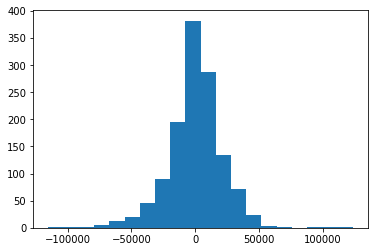

21966.026053167723

In [13]:
predictors = ['Country', 'Currency', 'YearsCodedJob']
res1 = regression(keep_columns(df, predictors),
                  model=linear_model.LinearRegression())
res1.rmsd

5
10
15
20
25
30
35
40
45


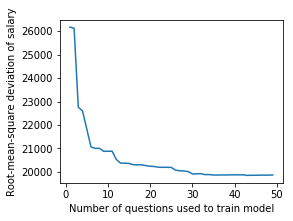

In [14]:
# This cell takes a couple minutes to run
n_questions = list(range(1, 50))
rmsds = []
for n in n_questions:
    result = ten_fold_rmsd(keep_columns(df, most_correlated_inputs[:n]),
                           model=linear_model.Ridge())
    rmsds.append(result)
    if n % 5 == 0: print(n)

plt.figure(figsize=(4, 3))
plt.xlabel('Number of questions used to train model')
plt.ylabel('Root-mean-square deviation of salary')
plt.plot(n_questions, rmsds)
plt.show()

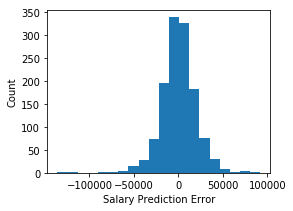

(19588.6608224789,
 {'.NET Core': -955120914091191.2,
  'Agile': 867.0997312736154,
  'Amazon Web Services (AWS)': 1083275879992547.0,
  'Android': -2124502292848121.2,
  'Android Studio': -473.07912275299066,
  'Android app': -112.81513002315907,
  'Android browser': 21.034953695466584,
  'AngularJS': -731953715709283.2,
  'AnnoyingUI_Agree': -2400.6272397299654,
  'AnnoyingUI_Disagree': -2167.8497776153495,
  'AnnoyingUI_Somewhat agree': -2922.323602819705,
  'AnnoyingUI_Strongly agree': -2931.8492049730885,
  'AnnoyingUI_Strongly disagree': -5890.343894920324,
  'Annual bonus': 2166.332833842074,
  'Arduino': -545719605843000.6,
  'Assembly': -298669733395363.7,
  'AssessJobCommute_Important': -9397.37868303919,
  'AssessJobCommute_Not at all important': -11961.5815013613,
  'AssessJobCommute_Not very important': -9759.693353969416,
  'AssessJobCommute_Somewhat important': -10066.084509167698,
  'AssessJobCommute_Very important': -8856.330686864425,
  'AssessJobCompensation_Importan

In [15]:
plt.figure(figsize=(4, 3))
plt.xlabel('Salary Prediction Error')
plt.ylabel('Count')
all_predictor_cols = [col for col in column_mapping.keys() if col != 'Salary']
all_questions_result = regression(keep_columns(df, all_predictor_cols),
                                  linear_model.LinearRegression())
all_questions_result.rmsd, all_questions_result.coefficients

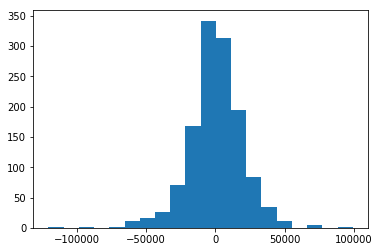

(19885.279599462916,
 {'.NET Core': 7.86204990526283,
  'Agile': 1105.0419506285034,
  'Amazon Web Services (AWS)': 893.6846234687724,
  'Android': -88.78769431435015,
  'Android Studio': -497.60958263130135,
  'Android app': -359.094850114653,
  'Android browser': -195.96529321465826,
  'AngularJS': 14.418014398487726,
  'AnnoyingUI_Agree': -1627.0873890704306,
  'AnnoyingUI_Disagree': 29.26560680409361,
  'AnnoyingUI_Somewhat agree': -2217.4925662839473,
  'AnnoyingUI_Strongly agree': -1818.1137235448903,
  'AnnoyingUI_Strongly disagree': -5895.536727956982,
  'Annual bonus': 1972.6104682100427,
  'Arduino': 45.275456376076264,
  'Assembly': -1330.1381127147206,
  'AssessJobCommute_Important': -9613.7736650498,
  'AssessJobCommute_Not at all important': -11038.447219409945,
  'AssessJobCommute_Not very important': -9118.372581320182,
  'AssessJobCommute_Somewhat important': -10609.376169451285,
  'AssessJobCommute_Very important': -9123.785800299835,
  'AssessJobCompensation_Importan

In [16]:
ridge_results = regression(keep_columns(df, all_predictor_cols),
                           linear_model.Ridge())
ridge_results.rmsd, ridge_results.coefficients

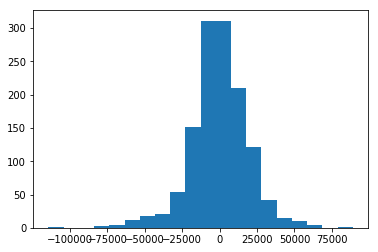

(19141.12105026996,
 {'.NET Core': -4.124709302672663,
  'Agile': 754.7082892746953,
  'Amazon Web Services (AWS)': 0.06038324766465062,
  'Android': 0.2570031518696176,
  'Android Studio': -375.4131464315669,
  'Android app': -12.611777381379069,
  'Android browser': -142.97397623390057,
  'AngularJS': 0.0,
  'AnnoyingUI_Agree': -785.3290938342928,
  'AnnoyingUI_Disagree': 526.6125903806045,
  'AnnoyingUI_Somewhat agree': -1539.7510745514896,
  'AnnoyingUI_Strongly agree': -887.6382486594358,
  'AnnoyingUI_Strongly disagree': -2849.7658704684477,
  'Annual bonus': 2227.4880506621366,
  'Arduino': -73.09355726787845,
  'Assembly': -307.99526469699595,
  'AssessJobCommute_Important': -2843.513568101724,
  'AssessJobCommute_Not at all important': -5144.817614525577,
  'AssessJobCommute_Not very important': -2713.5626856125596,
  'AssessJobCommute_Somewhat important': -3636.1047298480835,
  'AssessJobCommute_Very important': -2397.7156000276536,
  'AssessJobCompensation_Important': -153.9

In [17]:
lasso_results = regression(keep_columns(df, all_predictor_cols),
                           linear_model.Lasso(alpha=2))
lasso_results.rmsd, lasso_results.coefficients

In [18]:
all_cols_10fold_rmsd = ten_fold_rmsd(keep_columns(df, all_predictor_cols),
                                     model=linear_model.LinearRegression())
all_cols_10fold_rmsd

19680.59613085459

In [19]:
all_cols_10fold_rmsd_ridge = ten_fold_rmsd(keep_columns(df, all_predictor_cols),
                                           linear_model.Ridge())
all_cols_10fold_rmsd_ridge

19615.52629570965

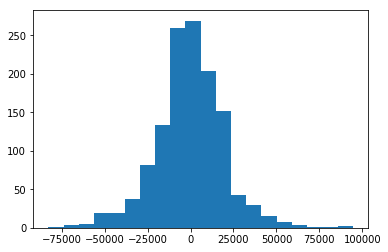

19830.063158083434

In [20]:
PCA = decomposition.PCA()
df_without_salary = df.drop(columns='Salary')
PCA.fit(df_without_salary)
pca_ndarray = PCA.transform(df_without_salary)
pca_cols = ['PC{}'.format(i) for i in range(len(df_without_salary.columns))]
pca_df = pd.DataFrame(pca_ndarray, index=df.index, columns=pca_cols)
pca_df['Salary'] = df['Salary']
pca_reg = regression(pca_df, linear_model.LinearRegression())
pca_reg.rmsd

In [21]:
results_by_pc = {}
for principal_component in pca_df.drop(columns='Salary').columns:
    result = regression(pca_df[[principal_component, 'Salary']],
                        linear_model.LinearRegression(),
                        plot=False)
    results_by_pc[principal_component] = result

In [22]:
most_correlated_pcs = sorted(results_by_pc.keys(), key=lambda pc: results_by_pc[pc].rmsd)

In [23]:
for principal_component in most_correlated_pcs:
    print('{}: {}'.format(principal_component, results_by_pc[principal_component].rmsd))

PC0: 35246.57077228556
PC488: 37477.052171308635
PC902: 37486.909601571955
PC241: 37517.70357531107
PC515: 37602.860412030524
PC470: 37696.33543155517
PC286: 37697.442447987356
PC13: 37870.25487938642
PC18: 37881.40944072392
PC503: 37904.195090956615
PC260: 37905.53939294306
PC563: 37922.781672249774
PC720: 37947.5147278144
PC30: 37986.173092338555
PC865: 38008.74097035662
PC451: 38008.79884316432
PC308: 38020.44917421007
PC763: 38116.49041048517
PC912: 38132.7587824391
PC302: 38141.31036198786
PC663: 38157.35170774404
PC463: 38158.420346984196
PC870: 38183.95262828662
PC722: 38209.30401603446
PC809: 38211.64366688447
PC785: 38221.90581620046
PC207: 38231.23386985142
PC707: 38251.086903066454
PC395: 38259.042932561984
PC746: 38269.192567220714
PC886: 38295.55768771637
PC405: 38322.51697988358
PC610: 38335.40138772871
PC946: 38341.91038066264
PC815: 38387.69983123608
PC483: 38400.350034882234
PC509: 38407.36985655694
PC15: 38418.94888739938
PC379: 38419.144613748365
PC133: 38427.4233449

In [24]:
npcs = list(range(1, 984, 25))
pca_rmsds = []
for npc in npcs:
    cols = most_correlated_pcs[:npc] + ['Salary']
    result = regression(pca_df[cols],
                        linear_model.LinearRegression(),
                        plot=False)
    pca_rmsds.append(result.rmsd)
    if ((npc - 1) % 100 == 0): print(npc)

1
101
201
301
401
501
601
701
801
901


In [25]:
cols = most_correlated_pcs + ['Salary']
result = regression(pca_df[cols],
                    linear_model.LinearRegression(),
                    plot=False)

In [26]:
result.rmsd

19150.437287193632

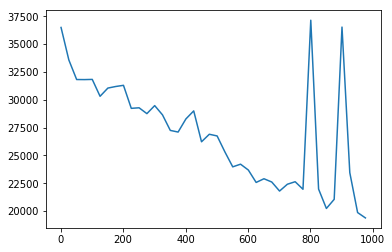

In [27]:
plt.plot(npcs, pca_rmsds)